In [1]:
print("Hello World!")

Hello World!


In [2]:
from SProjectD import lyman

In [ ]:
redshift=3.1
linewidth_red=120. #km/s; 
linewidth_blue=90.
asym_red=0.3 #asymetry of the line
asym_blue=-0.3
peaksep=300. #km/s
relative_peakflux_bluered=0.5

## Fit functions

In [61]:
def _1gaussian(x, *p):
    amp1,cen1,sigma1 = p
    return amp1*(1/(sigma1*(numpy.sqrt(2*numpy.pi))))*(numpy.exp(-((x-cen1)**2)/((2*sigma1)**2)))


def _2gaussian(x, *p):
    amp1,cen1,sigma1, amp2,cen2,sigma2 = p
    return amp1*(1/(sigma1*(numpy.sqrt(2*numpy.pi))))*(numpy.exp(-((x-cen1)**2)/((2*sigma1)**2))) +\
           amp2*(1/(sigma2*(numpy.sqrt(2*numpy.pi))))*(numpy.exp(-((x-cen2)**2)/((2*sigma2)**2)))



def fit1g(x,y,ini1,pds1):
    #one-gaussian
    popt_gauss_1, pcov_gauss_1 = curve_fit(_1gaussian, x, y, p0=ini1, bounds = pds1)
    y_fit_1 = _1gaussian(x,*popt_gauss_1)
    return y_fit_1
     
def fit2g(x,y,ini2,pds2):
    popt_gauss_2, pcov_gauss_2 = curve_fit(_2gaussian, x, y,p0=ini2,bounds = pds2)
    pars_1 = popt_gauss_2[0:3]
    pars_2 = popt_gauss_2[3:6]
    gauss_peak_1 = _1gaussian(x,*pars_1)
    gauss_peak_2 = _1gaussian(x,*pars_2)
    return gauss_peak_1+ gauss_peak_2


## Generate data part


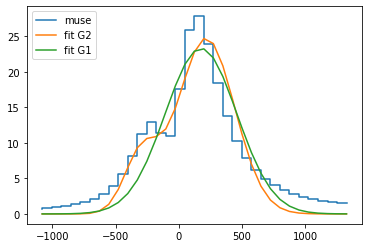

In [98]:
%matplotlib inline
from matplotlib import pyplot

#import data class and generate fake data
data = lyman(3.1, 120, 90, 0.3,-0.3, 300, 0.5)

intrin_x = data.xx
intrin_y = data.intrinsic_double()

smooth_y = data.smooth()

muse_x = data.MuseData()[0]
muse_y = data.MuseData()[1]

#fit the fake data
fit_y_2 = fit2g(muse_x,muse_y,p0,bds_2)
fit_y_1 = fit1g(muse_x,muse_y,p0[:3],bds_1)


#pyplot.plot(intrin_x,intrin_y, "--", label = "intrinsic")
#pyplot.plot(intrin_x,smooth_y, "-", label = "smoothed")
pyplot.step(muse_x,muse_y, "-", label = "muse")
pyplot.plot(muse_x,fit_y_2,"-", label = "fit G2")
pyplot.plot(muse_x,fit_y_1,"-", label = "fit G1")
pyplot.legend(loc=2)
pyplot.show() #scattering change the direction and frequency

## Fit data

In [75]:
p0=(50,-500,20,50,500,20)
bds_2 = ([1,-1000,1,1,0,1],[100000,0,200,100000,1000,200])
bds_1 = ([1,-1000,1],[100000,1000,200])


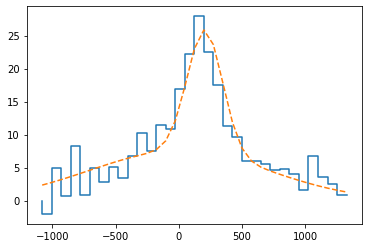

In [55]:
pyplot.step(muse_x,muse_y, "-", label = "muse")
pyplot.plot(muse_x,fit_y, "--", label = "fit")

## Sequence graph

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


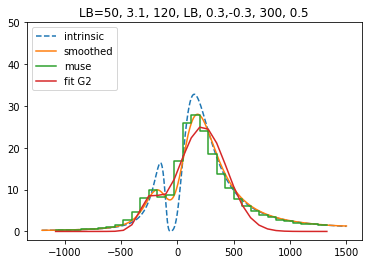

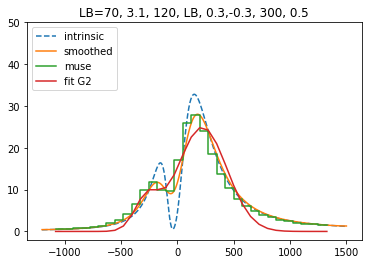

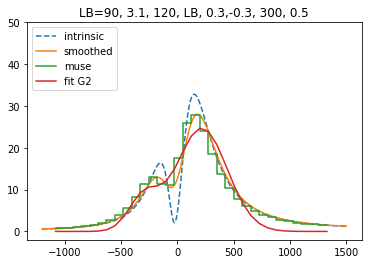

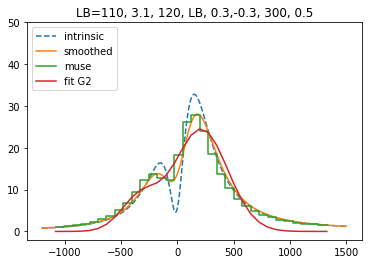

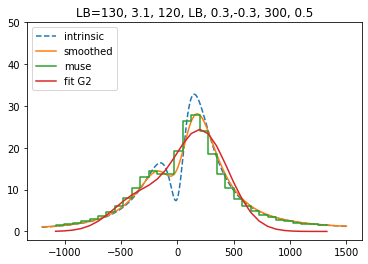

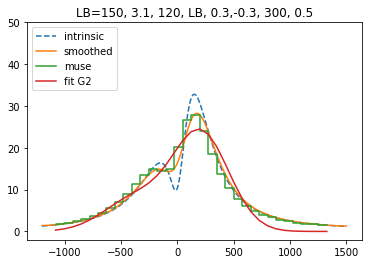

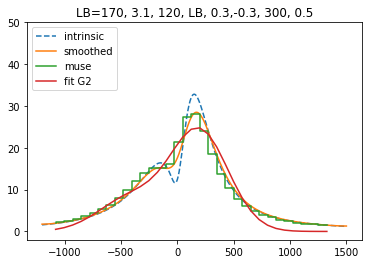

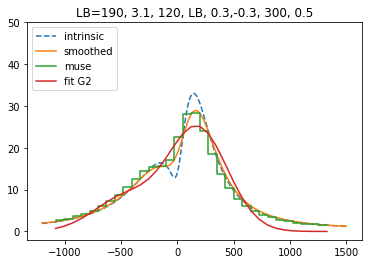

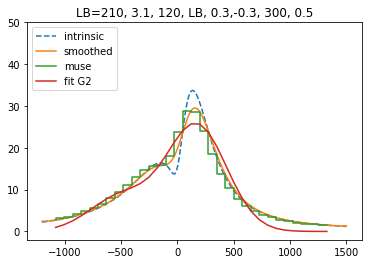

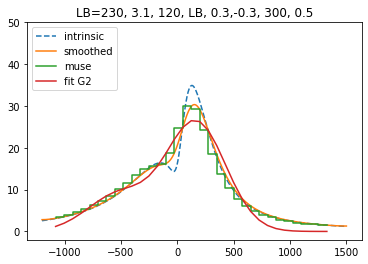

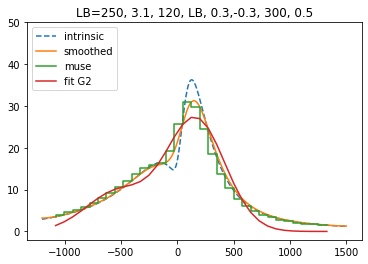

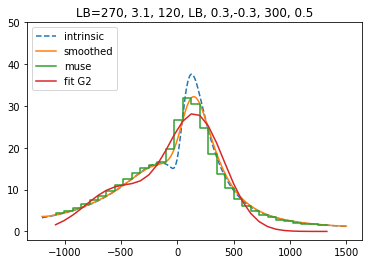

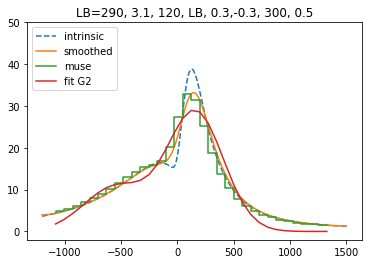

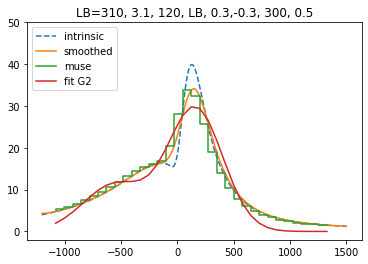

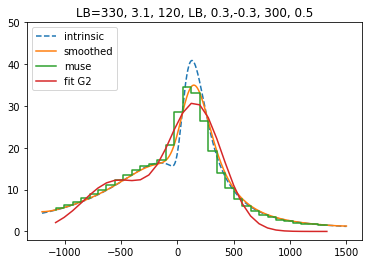

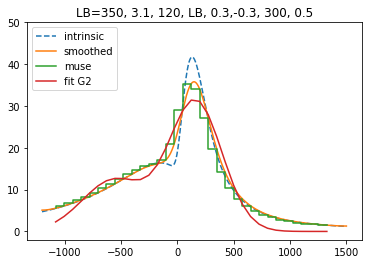

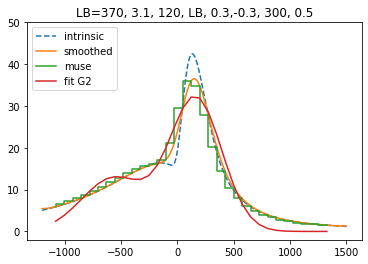

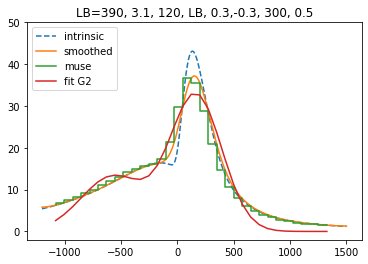

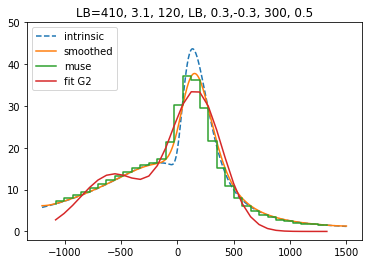

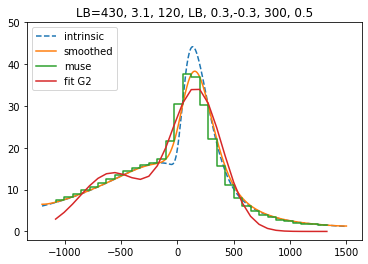

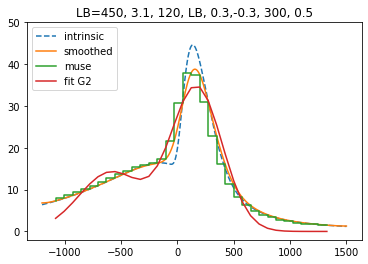

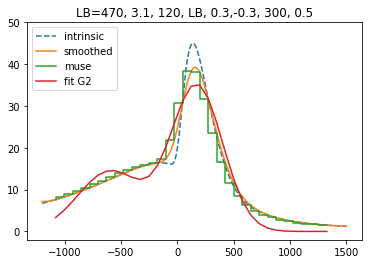

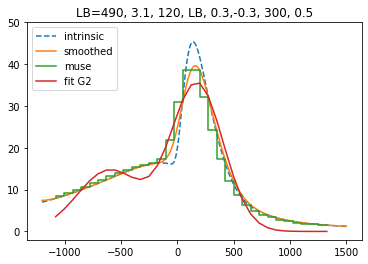

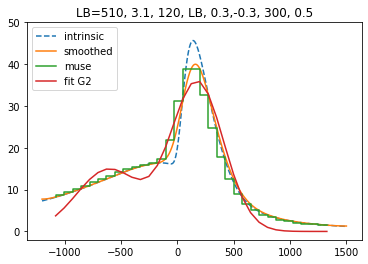

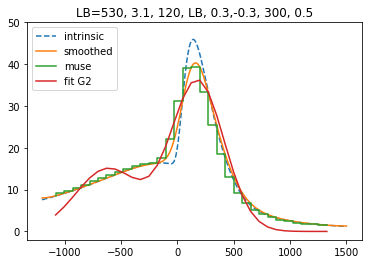

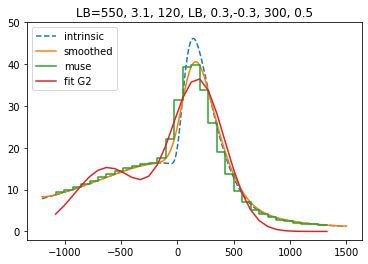

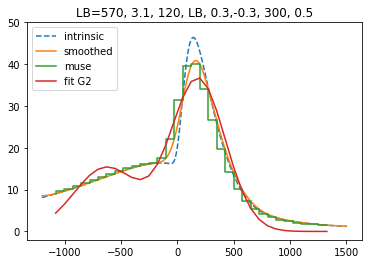

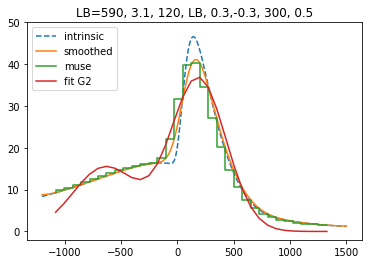

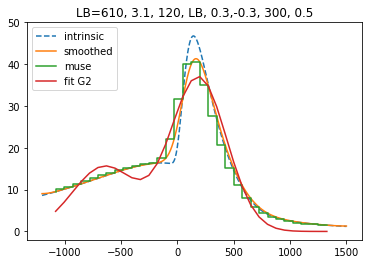

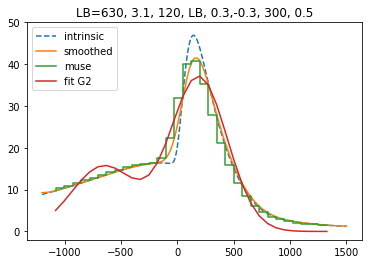

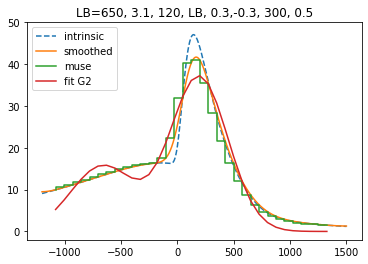

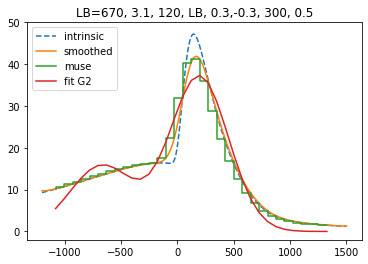

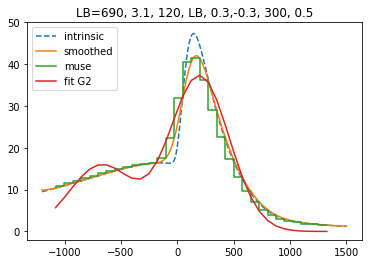

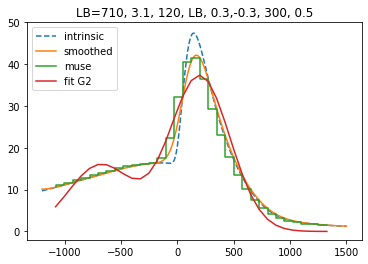

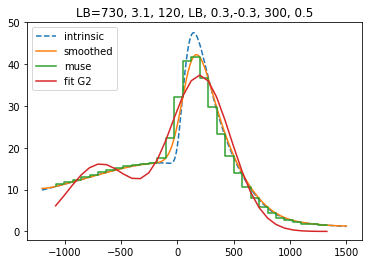

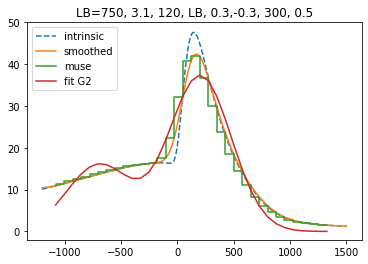

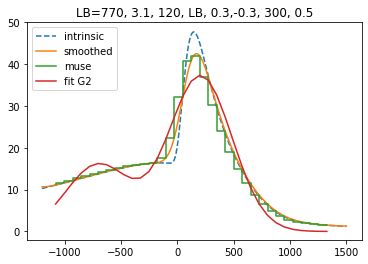

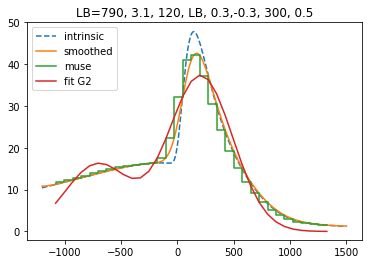

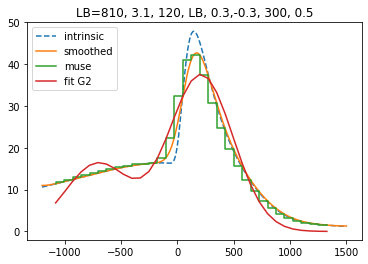

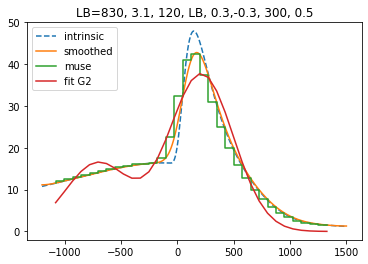

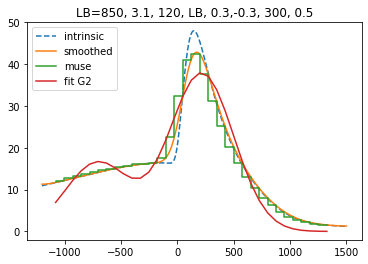

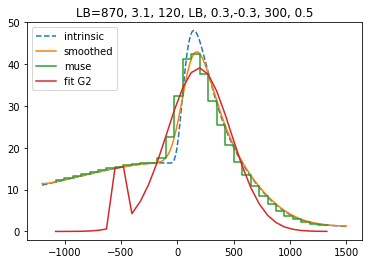

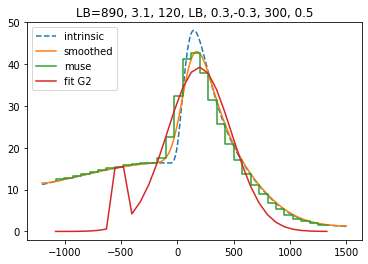

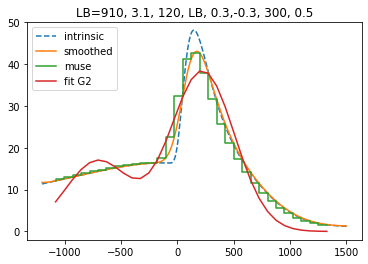

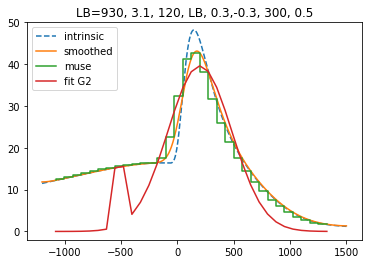

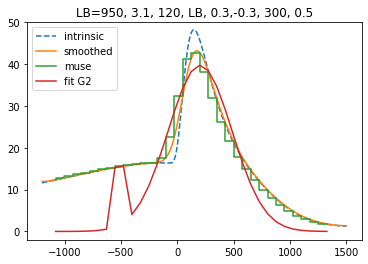

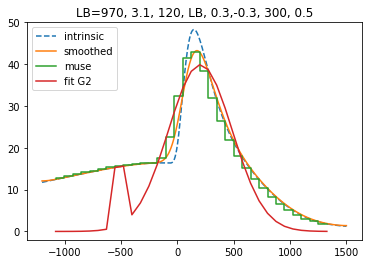

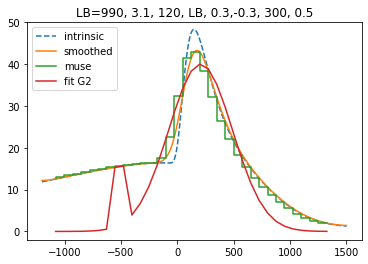

In [96]:
i = 0
for LB in range(50,1000,20):
    i += 1
    #import data class and generate fake data
    data = lyman(3.1, 120, LB, 0.3,-0.3, 300, 0.5)

    intrin_x = data.xx
    intrin_y = data.intrinsic_double()

    smooth_y = data.smooth()

    muse_x = data.MuseData()[0]
    muse_y = data.MuseData()[1]

    #fit the fake data
    fit_y_2 = fit2g(muse_x,muse_y,p0,bds_2)
    fit_y_1 = fit1g(muse_x,muse_y,p0[:3],bds_1)

    pyplot.figure()
    pyplot.ylim(-2,50)
    pyplot.plot(intrin_x,intrin_y, "--", label = "intrinsic")
    pyplot.plot(intrin_x,smooth_y, "-", label = "smoothed")
    pyplot.step(muse_x,muse_y, "-", label = "muse")
    pyplot.plot(muse_x,fit_y_2,"-", label = "fit G2")
    #pyplot.plot(muse_x,fit_y_1,"-", label = "fit G1")
    pyplot.legend(loc=2)
    pyplot.title("LB={}, 3.1, 120, LB, 0.3,-0.3, 300, 0.5".format(LB))
    pyplot.savefig("{}".format(i))
    #pyplot.show()

## Fitting using LM fit

In [ ]:
from lmfit import Model

def smoothed_skewed_gaussian(x,a,x0,asym,d):
    LSF_SIGMA_dx=35.25/40. #hardcoded thing, 40=km/s per MUSE spectral pixel
    return snd.gaussian_filter(a*numpy.exp((-(x-x0)**2)/(2*(asym*(x-x0)+d)**2)),sigma=LSF_SIGMA_dx)

twomodel = Model(smoothed_skewed_gaussian) 
twomodel.set_param_hint('asym',min=0.,max=0.4)
twomodel.set_param_hint('d',min=30.,max=100.)
twomodel.set_param_hint('x0',min=-20.,max=20.)

twoparams = twomodel.make_params(x0=0,asym=0.25, d=80.) 

tworesult = twomodel.fit(flux_data, twoparams, x=velocity_data,nan_policy='omit',weights=flux_err)

print tworesult.fit_report()

print tworesult.params['x0'].value #just example to print best-fitted x0

xx=numpy.arange(-1500,1500,0.1) #this is just for plotting
pyplot.plot(xx,twomodel.eval(tworesult.params,x=xx)) #plot the best fit
pyplot.show()



In [125]:
import scipy.ndimage as snd
from lmfit import Model

#Skewed gaussian functions

def sk_ga1(x,a_1,x0_1,asym_1,d_1):
    return a_1*numpy.exp((-(x-x0_1)**2)/(2*(asym_1*(x-x0_1)+d_1)**2))

def sk_ga2(x,a_1,x0_1,asym_1,d_1,a_2,x0_2,asym_2,d_2):
    g1 = sk_ga1(x,a_1,x0_1,asym_1,d_1)
    g2 = sk_ga1(x,a_2,x0_2,asym_2,d_2)
    return g1+g2

#initiate lmfit 


lmG2 = Model(sk_ga2)
print('parameter names: {}'.format(lmG2.param_names))
print('independent variables: {}'.format(lmG2.independent_vars))

lmG1 = Model(sk_ga1)
print('parameter names: {}'.format(lmG1.param_names))
print('independent variables: {}'.format(lmG1.independent_vars))

#set initial values and boundaries
params = lmG2.make_params(a_1=20, x0_1=-250, asym_1=0.25, d_1 = 25,a_2=20, x0_2=250, asym_2=0.25,d_2 = 25)

lmG2.set_param_hint('a_1', min = 0, max = 100)
lmG2.set_param_hint('x0_1', min = -500, max = 0)
lmG2.set_param_hint('asym_1', min = 0, max = 0.4)
lmG2.set_param_hint('d_1', min = 20, max = 100)
lmG2.set_param_hint('a_2', min = 0, max = 100)
lmG2.set_param_hint('x0_2', min = 0, max = 500)
lmG2.set_param_hint('asym_2', min = 0, max = 0.4)
lmG2.set_param_hint('d_2', min = 20, max = 100)





parameter names: ['a_1', 'x0_1', 'asym_1', 'd_1', 'a_2', 'x0_2', 'asym_2', 'd_2']
independent variables: ['x']
parameter names: ['a_1', 'x0_1', 'asym_1', 'd_1']
independent variables: ['x']


In [126]:
#generate a test data 

data = lyman(3.1, 120, 90, 0.3,-0.3, 300, 0.5)
muse_x = data.MuseData()[0]
muse_y = data.MuseData()[1]

result = lmG2.fit(muse_y, params, x=muse_x)
print(result.fit_report())

[[Model]]
    Model(sk_ga2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18004
    # data points      = 33
    # variables        = 8
    chi-square         = 115.234356
    reduced chi-square = 4.60937422
    Akaike info crit   = 57.2651921
    Bayesian info crit = 69.2372526
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a_1:     1.6634e+29 (init = 20)
    x0_1:   -252.236287 (init = -250)
    asym_1:  0.08684848 (init = 0.25)
    d_1:     0.07558740 (init = 25)
    a_2:     23.2332710 (init = 20)
    x0_2:    191.506441 (init = 250)
    asym_2:  0.09590094 (init = 0.25)
    d_2:     169.018220 (init = 25)


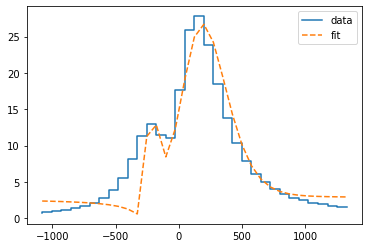

In [211]:
pyplot.step(muse_x, muse_y, '-', label = "data")
pyplot.plot(muse_x, result.best_fit, '--',label = 'fit')
pyplot.legend()
pyplot.show()

In [128]:
result

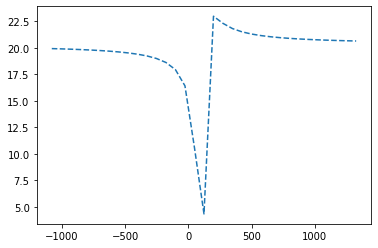

In [124]:
y = sk_ga1(muse_x,23,190,2,170)
pyplot.plot(muse_x, y, '--')

#### First attempt to fit data with ml and skewed gaussian. Turns out skewed gaussian function gives this shape. Next step, try to use a different skewed Gaussian function to fit the data

## New Skewed Gaussian function

In [192]:
from scipy.special import erf

def ga1_sk(x, amp1,cen1,asym1,sigma1):
    norm = amp1*(1/(sigma1*(numpy.sqrt(2*numpy.pi))))*(numpy.exp(-((x-cen1)**2)/((2*sigma1)**2)))
    cdf = 0.5*(1+erf(asym1*(x-cen1)/(sigma1*2**0.5)))
    return norm*cdf

def ga2_sk(x,amp1,cen1,asym1,sigma1,amp2,cen2,asym2,sigma2):
    g1 = ga1_sk(x,amp1,cen1,asym1,sigma1)
    g2 = ga1_sk(x,amp2,cen2,asym2,sigma2)
    return g1+g2

In [189]:
G2lm = Model(ga2_sk)
print('parameter names: {}'.format(G2lm.param_names))
print('independent variables: {}'.format(G2lm.independent_vars))

G1lm = Model(ga1_sk)
print('parameter names: {}'.format(G1lm.param_names))
print('independent variables: {}'.format(G1lm.independent_vars))

#set initial values and boundaries
params_new = G2lm.make_params(amp1=20, cen1=-250, asym1=0.25, sigma1 = 25, amp2=20, cen2=250, asym2=0.25,sigma2 = 25)

G2lm.set_param_hint('amp1', min = 0, max = 100)
G2lm.set_param_hint('cen1', min = -500, max = 0)
G2lm.set_param_hint('asym1', min = -10, max = 10)
G2lm.set_param_hint('sigma1', min = 5, max = 80)
G2lm.set_param_hint('amp2', min = 0, max = 100)
G2lm.set_param_hint('cen2', min = 0, max = 500)
G2lm.set_param_hint('asym2', min = -10, max = 10)
G2lm.set_param_hint('sigma2', min = 5, max = 80)

parameter names: ['amp1', 'cen1', 'asym1', 'sigma1', 'amp2', 'cen2', 'asym2', 'sigma2']
independent variables: ['x']
parameter names: ['amp1', 'cen1', 'asym1', 'sigma1']
independent variables: ['x']


[[Model]]
    Model(ga2_sk)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1213
    # data points      = 33
    # variables        = 8
    chi-square         = 31.7181406
    reduced chi-square = 1.26872562
    Akaike info crit   = 14.6925800
    Bayesian info crit = 26.6646405
[[Variables]]
    amp1:    4860.49792 +/- 3253.16106 (66.93%) (init = 20)
    cen1:    123.240309 +/- 115.974491 (94.10%) (init = -250)
    asym1:   5013.75019 +/- 36631403.8 (730618.85%) (init = 0.25)
    sigma1:  122.140489 +/- 46.9879332 (38.47%) (init = 25)
    amp2:    21233.1382 +/- 1106.07017 (5.21%) (init = 20)
    cen2:   -261.792684 +/- 70.2376716 (26.83%) (init = 250)
    asym2:   1.35405961 +/- 0.47751024 (35.27%) (init = 0.25)
    sigma2:  433.658446 +/- 49.4022675 (11.39%) (init = 25)
[[Correlations]] (unreported correlations are < 0.100)
    C(cen1, asym1)    =  1.000
    C(amp1, sigma1)   =  0.981
    C(amp1, cen1)     = -0.973
    C(amp1, asym1)    = -0.973
    C(ce

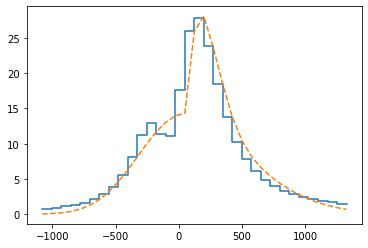

In [209]:
result_new = G2lm.fit(muse_y, params_new, x=muse_x, method = 'leastsq')
print(result_new.fit_report())

pyplot.step(muse_x, muse_y, '-')
pyplot.plot(muse_x, result_new.best_fit, '--')

pyplot.show()

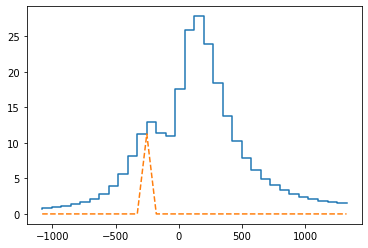

In [198]:
pyplot.step(muse_x, muse_y, '-')
pyplot.plot(muse_x, result_new.best_fit, '--')

pyplot.show()